In [1]:
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import math 
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

from coffea.nanoaod import NanoEvents

file = '/eos/uscms/store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_308.root'
events = NanoEvents.from_file(file)

In [24]:
from coffea import processor, hist

class MyZPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("flavor", "flavor name"),
            hist.Bin("pt", "electron pt", 100, 0, 120),
        )
    
    @property
    def accumulator(self):
        return self._histo
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        electron = events.Electron
        muon = events.Muon
        tau = events.Tau
#         mmevents = events[events.Muon.counts == 2]
#         zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
        out.fill(
            flavor='electron',
            pt=electron.pt.flatten(),
        )
        out.fill(
            flavor='muon',
            pt=muon.pt.flatten(),
        )
        out.fill(
            flavor='tau',
            pt=tau.pt.flatten(),
        )
        return out
    
    def postprocess(self, accumulator):
        return accumulator
            

In [25]:
samples = {
    "WJets": [
        '/eos/uscms/store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_308.root',
    ]
}

result = processor.run_uproot_job(
    samples,
    "Events",
    MyZPeak(),
    processor.iterative_executor,
    {"nano": True},
)

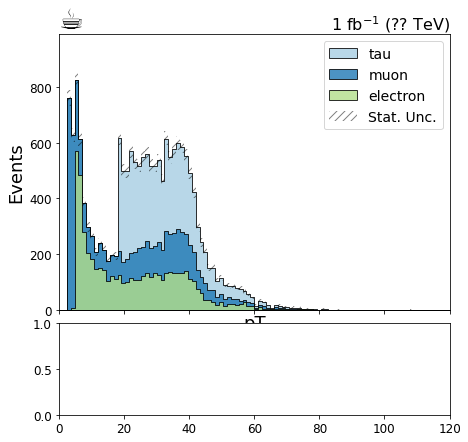

In [34]:
# make a nice ratio plot, adjusting some font sizes
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

# Here is an example of setting up a color cycler to color the various fill patches
# We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

# plot the MC first
hist.plot1d(
    result ,
    overlay="flavor", 
    ax=ax,
    clear=False,
    stack=True, 
    line_opts=None,
    fill_opts=fill_opts,
    error_opts=error_opts
)

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel('pT')
leg = ax.legend()


coffee = plt.text(0., 1., u"☕",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (?? TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )


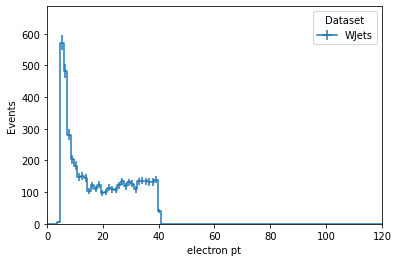